### This example notebook shows the procedure of LHA molecular parcellation based on selective enrichment of Slc17a6/Slc32a1 and Otp/Meis2

In [33]:
import os, sys
sys.path.append('../..')
import numpy as np
import pandas as pd
from glob import glob
from easi_fish import parcellation

### Load data files

In [39]:
lha_neuron=pd.read_csv('/EASI-FISH/LHA_analysis/LHA_data/EASI_FISH_gene_count.csv',sep=',', index_col=0)
roi=pd.read_csv('/EASI-FISH/LHA_analysis/LHA_data/EASI_FISH_metadata.csv',sep=',', index_col=0)
c=['Ex-1', 'Ex-2', 'Ex-3', 'Ex-4',
   'Ex-5', 'Ex-6', 'Ex-7', 'Ex-8', 
   'Ex-9', 'Ex-10', 'Ex-11', 'Ex-12', 
   'Ex-13', 'Ex-14', 'Ex-15', 'Ex-16', 
   'Ex-17', 'Ex-18', 'Ex-19', 'Ex-20',
   'Ex-21', 'Ex-22', 'Ex-23', 'Ex-24', 
   'Ex-25','Inh-1', 'Inh-2','Inh-3', 'Inh-4', 
   'Inh-5', 'Inh-6', 'Inh-7', 'Inh-8', 'Inh-9', 
   'Inh-10', 'Inh-11', 'Inh-12', 'Inh-13', 'Inh-14',
   'Inh-15', 'Inh-16', 'Inh-17', 'Inh-18', 'Inh-19',
   'Inh-20', 'Inh-21', 'Inh-22', 'Inh-23']

### Compute the relative expression of Otp and Meis2 in LHA3

In [19]:
roi_lha3=roi[roi.index.str.contains('LHA3')]
roi_lha3=parcellation.relative_expression(roi_lha3, lha_neuron[lha_neuron.index.str.contains('LHA3')],'Otp','Meis2',50)

### Plot the relative expression in LHA3

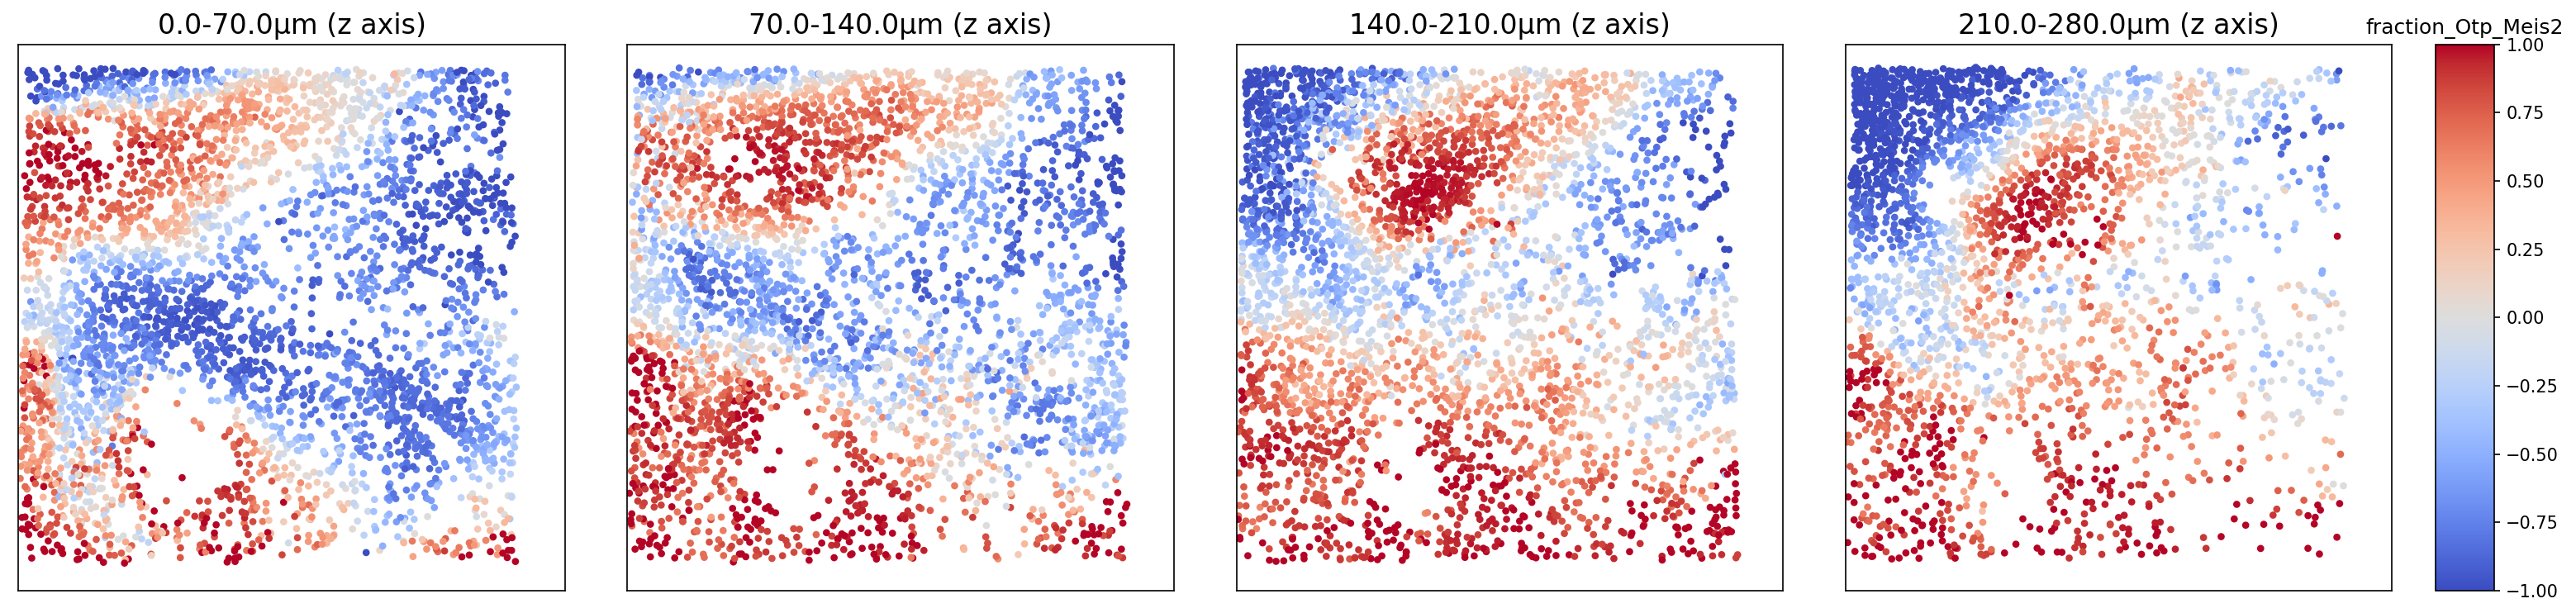

In [21]:
parcellation.plot_relative_expression(roi_lha3,'fraction_Otp_Meis2',4,invert_y=True, invert_z=True)

### Compute the relative expression of Slc17a6 and Slc32a1 in the LHA

In [17]:
roi_lha3=parcellation.relative_expression(roi_lha3, lha_neuron[lha_neuron.index.str.contains('LHA3')],'Slc17a6','Slc32a1',50)

### Plot the relative expression in LHA3

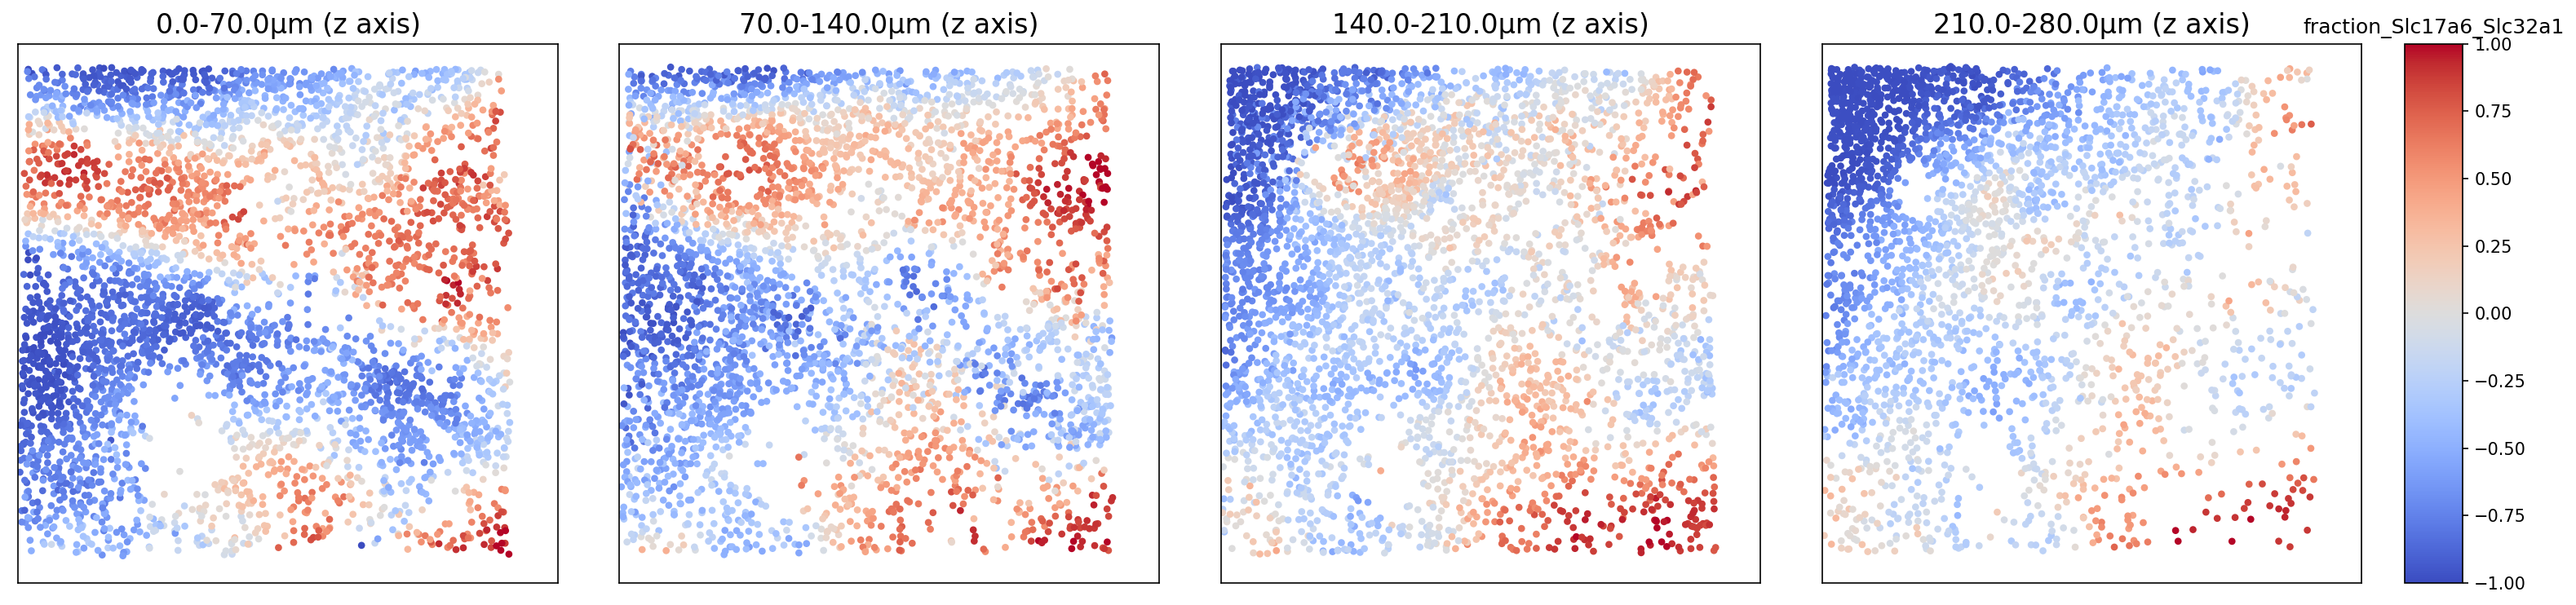

In [22]:
parcellation.plot_relative_expression(roi_lha3,'fraction_Slc17a6_Slc32a1',4,invert_y=True, invert_z=True)

### Classification with Slc17a6, Slc32a1, Otp and Meis2 (LHA3 used as an example here)

In [24]:
for i in roi_lha3.index:
    if roi_lha3.loc[i, 'fraction_Otp_Meis2']> 0:
        if roi_lha3.loc[i, 'fraction_Slc17a6_Slc32a1']> 0:
            roi_lha3.loc[i,'classifier']='1' #Slc17a6_otp
        else:
            roi_lha3.loc[i,'classifier']='2'  #Slc32a1_otp
    else:
        if roi_lha3.loc[i, 'fraction_Slc17a6_Slc32a1']> 0:
            roi_lha3.loc[i,'classifier']='3' #Slc17a6_meis2
        else:
            roi_lha3.loc[i,'classifier']='4' #Slc32a1_meis2

/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


### LHA segmentation using Gaussian mixture model (LHA3 as an example)
The code below is for demonstration purpose. 
For the analysis described in the paper, entire image volumes were segmented at 1µm resolution from all biological replicates.  

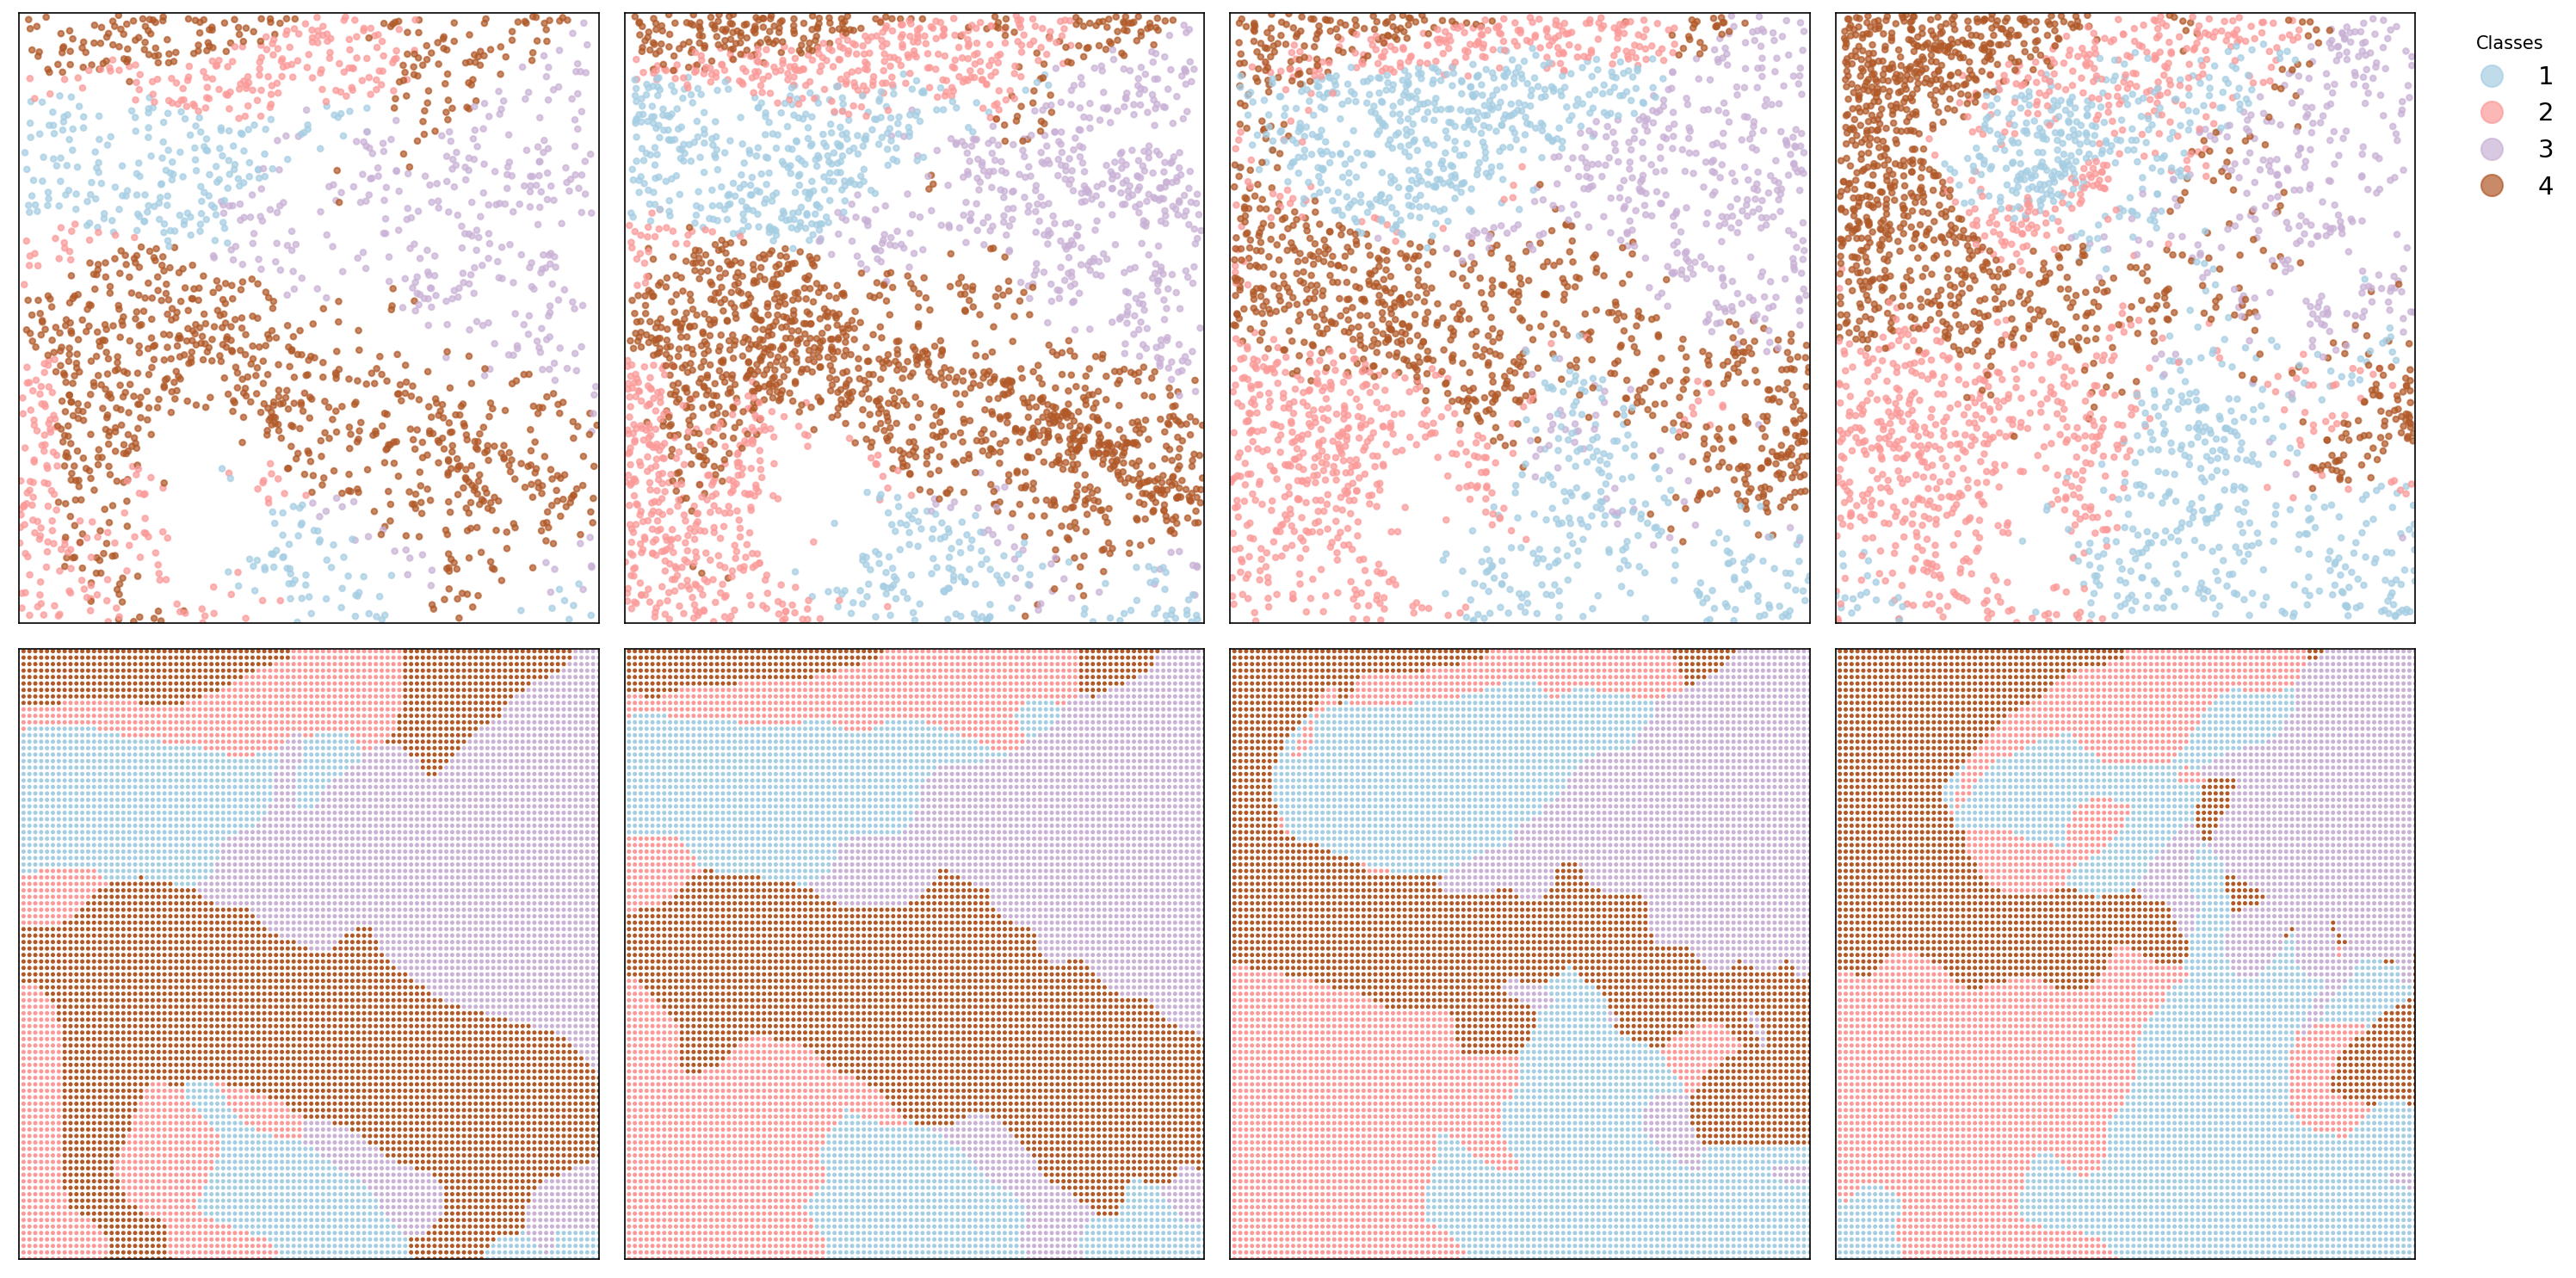

In [28]:
###3D model 
import matplotlib.pyplot as plt 
from sklego.mixture import GMMClassifier
# from sklego.mixture import GMMOutlierDetector
fig,ax=plt.subplots(2,4,figsize=(20,10),dpi=150)
ind=0
A=roi_lha3.copy()
A=A[(A.x<777)&(A.y<772)&(A.z<266)]
A.z=A.z.max()-A.z

mod = GMMClassifier(n_components=50).fit(A.to_numpy()[:,0:3][:,[2,1,0]], A['classifier'])

for z in [36, 86, 146, 206]:
    B=A[(A.z>(z-60))&(A.z<=z)]
    a = np.linspace(0, 777, 100)  
    b = np.linspace(0, 772, 100)
    c= np.linspace(z-20, z-19, 1)   
    xa, xb,xc = np.meshgrid(a, b, c) 
    U=np.zeros((xa.flatten().shape[0],3))
    U[:,0] = xa.flatten()
    U[:,1] = xb.flatten()
    U[:,2] = xc.flatten()
    Z=mod.predict(U).astype(float)
    a=ax[1,ind].scatter(U[:, 0], U[:, 1], c=Z, s=2,cmap=plt.cm.Paired)
    a=ax[0,ind].scatter(B.x, B.y, c=B.classifier.astype('float'), s=10,alpha=0.7,cmap=plt.cm.Paired)
    for mm in range(0,2):
        ax[mm,ind].xaxis.set_ticklabels([])
        ax[mm,ind].yaxis.set_ticklabels([])
        ax[mm,ind].xaxis.set_ticks([])
        ax[mm,ind].yaxis.set_ticks([])
        ax[mm,ind].set_ylim(36,772)
        ax[mm,ind].set_xlim(2,777)
        ax[mm,ind].invert_yaxis()
    ind+=1
legend1 = ax[0,ind-1].legend(*a.legend_elements(),
                        title="Classes",fontsize=14,
                        markerscale=2,bbox_to_anchor=(1.05, 1.0), 
                             loc='upper left',frameon=False)
plt.tight_layout()

### Find the optimal n_components for Gaussian mixture model

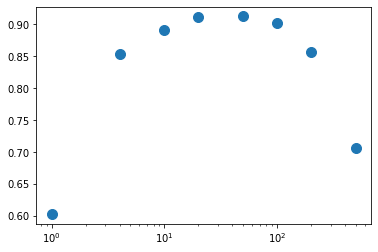

In [31]:
A=roi_lha3.copy()
A=A[(A.x<789)&(A.x>130)&(A.y>30)&(A.y<787)&(A.z>83)&(A.z<348)]
s=45
A.z=A.z.max()-A.z
n=8000
idx=np.random.choice(A.index,n)
X_train=A[A.index.isin(idx)].to_numpy()[:,0:3][:,[2,1,0]]
Y_train=A[A.index.isin(idx)]['classifier']

idx_t=np.random.choice(A[~A.index.isin(idx)].index, n)
X_test=A[A.index.isin(idx_t)].to_numpy()[:,0:3][:,[2,1,0]]
Y_test=A[A.index.isin(idx_t)]['classifier']
score={}
for i in [1,4,10,20,50,100,200,500]:
    mod = GMMClassifier(n_components=i).fit(X_train, Y_train)
    score[i]=mod.score(X_test, Y_test)
plt.scatter(score.keys(),score.values(),s=100)
plt.xscale('log')    